# Imports and fixing data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

from helper_methds import add_day_of_week, group_and_sum_by_day, group_and_sum_durations_by_day, \
    group_and_mean_by_day_of_week, group_and_mean_sums_by_day_of_week, filter_date_range, energy_model, \
    categorize_day_night_start_only, get_type_data, get_timeperiod_data, get_plot_kwargs, \
    get_consecutive_durations_from_two_dfs, make_year_heatmap, plot_fft_results, analyze_fft, \
    plot_heatmap_with_date_range, plot_heatmap_with_date_range_transpose

In [2]:
pd.__version__

'2.2.3'

In [3]:
pd.options.mode.copy_on_write = True

To make a new json file, do the following in this directory:
```
node convert_to_json.mjs PATH_TO_REALM.realm ./export.json
```

In [4]:
import json

# Open and read the JSON file
with open(("export.json"), 'r') as file:
# with open(("28-02-2025 07_49_03 mybaby-default.json"), 'r') as file:
    data = json.load(file)

full_df = pd.DataFrame.from_dict(data["EventItem"])
# full_df = full_df.set_index('id')

In [5]:
full_df.columns

Index(['id', 'babyId', 'comment', 'photo', 'type', 'enteredDate',
       'customComment', 'leftStart', 'leftEnd', 'rightStart', 'rightEnd',
       'leftSeconds', 'rightSeconds', 'mixType', 'bottleAmount',
       'bottleAmountOunce', 'weight', 'height', 'headCirc', 'temperature',
       'weightPounds', 'heightInches', 'headCircInches', 'temperatureFah',
       'breast', 'singleTimerStart', 'singleTimerSeconds',
       'doubleLeftTimerStart', 'doubleRightTimerStart',
       'doubleLeftTimerSeconds', 'doubleRightTimerSeconds'],
      dtype='object')

In [6]:
pd.unique(full_df.loc[:,"type"])

array(['lactation', 'bottle', 'pumping', 'taking_med', 'diaper',
       'temperature', 'vaccination', 'weight', 'height', 'head_circ',
       'bathing', 'sleep', 'custom_achieve', 'stroll', 'lure'],
      dtype=object)

## single instance

In [7]:
full_df.iloc[-1]

id                         816B287B-C6C0-4AB6-B94A-77E6ABFACC54
babyId                     50269EA9-7196-43CC-AAC7-996E4154C610
comment                                                        
photo                                                      None
type                                                      sleep
enteredDate                            2025-04-24T01:55:45.387Z
customComment                                                  
leftStart                              2025-04-24T01:30:45.000Z
leftEnd                                2025-04-24T01:55:45.387Z
rightStart                                                 None
rightEnd                                                   None
leftSeconds                                                   0
rightSeconds                                                  0
mixType                                                        
bottleAmount                                                   
bottleAmountOunce                       

## Fix date and numeric fields

In [8]:
date_fields = ['enteredDate', 'leftStart', 'leftEnd']
for field in date_fields:
    full_df[field] = pd.to_datetime(full_df[field], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
num_fields = ['leftSeconds',
              'rightSeconds', 
              'bottleAmount',
              'bottleAmountOunce', 
              'weight', 
              'height', 
              'headCirc' ,
              'temperature',
              'weightPounds',
              'heightInches',
              'headCircInches',
              'temperatureFah','singleTimerSeconds' ]
for field in num_fields:
    full_df[field] = pd.to_numeric(full_df[field])
    
sleep_err = 10*60 # 10 mins in seconds
bottle_err = 15 # ml

In [9]:
full_df.groupby('type').count()

,id,babyId,comment,photo,enteredDate,customComment,leftStart,leftEnd,rightStart,rightEnd,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
type,,,,,,,,,,,,,,,,,,,,,
bathing,38,38,38,0,38,38,38,38,0,0,...,0,0,0,38,0,4,0,0,0,0
bottle,1449,1449,1449,0,1449,1449,0,0,0,0,...,0,0,0,1449,0,0,0,0,0,0
custom_achieve,1,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
diaper,281,281,281,0,281,281,0,0,0,0,...,0,0,0,281,0,0,0,0,0,0
head_circ,8,8,8,0,8,8,0,0,0,0,...,0,8,0,8,0,0,0,0,0,0
height,9,9,9,0,9,9,0,0,0,0,...,9,0,0,9,0,0,0,0,0,0
lactation,156,156,156,0,156,156,156,156,0,0,...,0,0,0,156,0,0,0,0,5,4
lure,73,73,73,0,73,73,0,0,0,0,...,0,0,0,73,0,0,0,0,0,0
pumping,328,328,328,0,328,328,0,0,0,0,...,0,0,0,328,0,0,0,0,0,0


In [10]:
non_empty_strings = full_df[full_df['customComment'].str.strip().str.len() > 0]


In [11]:
non_empty_strings

,id,babyId,comment,photo,type,enteredDate,customComment,leftStart,leftEnd,rightStart,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
151,47907606-DEBC-415F-BBF5-29D8566623EA,50269EA9-7196-43CC-AAC7-996E4154C610,Gas\n,None,taking_med,2024-10-19 09:10:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
156,28405EC5-90DE-4F45-9EF4-09034D82F768,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-19 22:30:24-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
173,7D411CE4-2E1D-492A-90A1-10BA2F0B2D78,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 20:00:44-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
177,9AC2FF0A-F711-4DD3-ABFE-E6E812BBAA7E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 22:30:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
196,15711C94-D55C-4541-A27C-7F62FBBA0D0E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-21 22:30:12-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,7C336E52-89A3-41C8-A5FB-1717A452151F,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-04-23 16:00:38-04:00,Carrot apple,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3436,FD14A5F5-AE38-401A-9C30-9C336C29B22F,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-04-23 13:20:20-04:00,Chicken avocado,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3440,20C74E71-1CC6-4C91-B654-EAFC3B017E50,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-04-23 10:00:59-04:00,Apple carrot,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3443,0B90AA69-0155-4FA2-A11D-3CADD9D567F0,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-04-23 07:45:22-04:00,Apple pear oats,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN


## Helper methods

In [12]:



# # Example usage:
# # Assuming you have a DataFrame 'df' with columns 'date', 'sales', and 'units'

# # Group and sum by day
# daily_totals = group_and_sum_by_day(full_df[full_df['type']=='bottle'], 'enteredDate', ['bottleAmount'])

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')

# # day_of_week_totals = group_and_sum_by_day(daily_totals_with_day, 'day_of_week', ['bottleAmount'])

# # Filter for a specific date range
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-01-01', '2025-01-31')


In [13]:
from scipy.optimize import curve_fit

# # Your data
# time = np.array([...])  # Time points
# calories = np.array([...])  # Calorie intake

# # Initial parameter guesses
# p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# # Fit the model
# popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# # popt now contains the optimized parameters [E0, A, k, t0]


In [14]:


# Example usage:
# Assuming you have a DataFrame 'df' with columns 'start_time' and 'end_time'
# df = categorize_day_night_start_only(full_df[full_df['type']=='sleep'], 'leftStart')

In [15]:


# Example usage:
# scatter_kwargs = get_plot_kwargs('scatter')
# histogram_kwargs = get_plot_kwargs('histogram')


# Plots

## Feeding

### Daily feeding over time

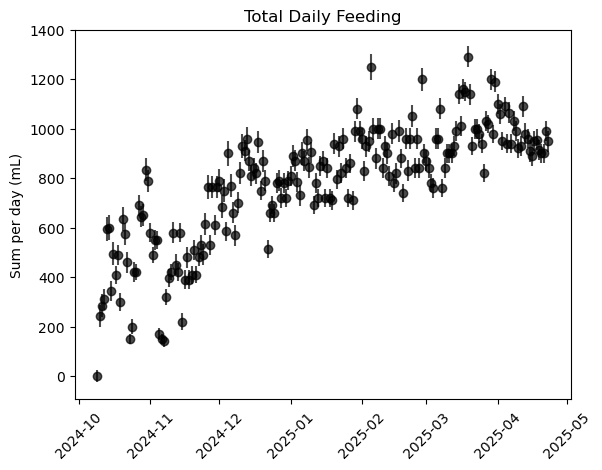

In [16]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'enteredDate', '2024-10-04', '2025-05-28')
df = categorize_day_night_start_only(get_type_data(filtered_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], err=bottle_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
plt.errorbar(daily_totals.loc[:,'enteredDate'], 
             daily_totals.loc[:,'bottleAmount_sum'],
             yerr=daily_totals.loc[:,'bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding.png")

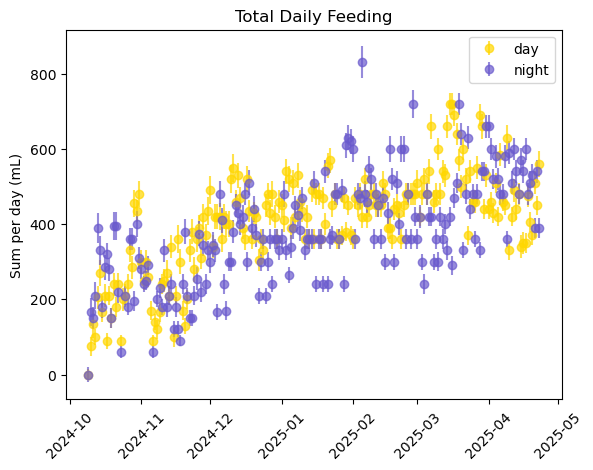

In [17]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], err=bottle_err)

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
# plt.errorbar(daily_totals.loc[:,'enteredDate'], 
#              daily_totals.loc[:,'bottleAmount_sum'], 
#              yerr=daily_totals.loc[:,'bottleAmount_err'], 
#              **get_plot_kwargs('all') )

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'], err=bottle_err)

    # Add day of week
    daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
    plt.errorbar(daily_totals['enteredDate'],
                 daily_totals['bottleAmount_sum'],
                 yerr=daily_totals['bottleAmount_err'],
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding_day_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_45689/3150256967.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(energy_model, time, calories, p0=p0)


(array([20089.20833333, 20103.20833333, 20120.20833333, 20134.20833333,
        20148.20833333, 20162.16666667, 20179.16666667, 20193.16666667]),
 [Text(20089.208333333332, 0, '2025-01-01'),
  Text(20103.208333333332, 0, '2025-01-15'),
  Text(20120.208333333332, 0, '2025-02-01'),
  Text(20134.208333333332, 0, '2025-02-15'),
  Text(20148.208333333332, 0, '2025-03-01'),
  Text(20162.166666666668, 0, '2025-03-15'),
  Text(20179.166666666668, 0, '2025-04-01'),
  Text(20193.166666666668, 0, '2025-04-15')])

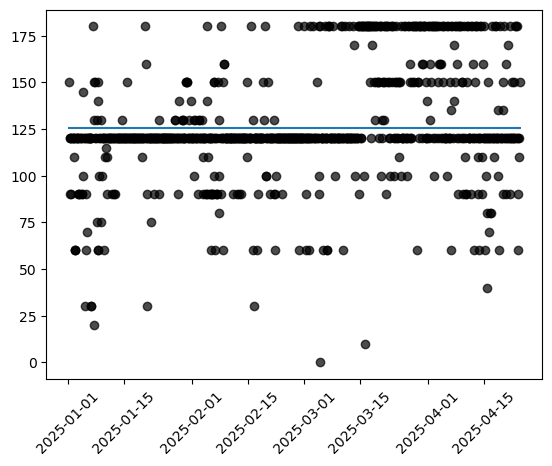

In [18]:
filtered_df = filter_date_range(full_df, 'enteredDate', '2025-01-01', '2025-05-28')
df = get_type_data(filtered_df, 'bottle')
# plt.plot(df['enteredDate'], df['bottleAmount'],'o')

# Your data
# Assuming 'df' is your pandas DataFrame and 'your_datetime_column' is the column name
datetime_array = df.loc[:,'enteredDate'].to_numpy()
earliest_datetime = datetime_array.min()

time = [(d-earliest_datetime).total_seconds() for d in datetime_array]
calories = df.loc[:,'bottleAmount'].to_numpy()  # Calorie intake

# Initial parameter guesses
p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# Fit the model
popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# popt now contains the optimized parameters [E0, A, k, t0]

plt.plot(datetime_array, energy_model(time, *popt))
plt.plot(datetime_array, calories, **get_plot_kwargs('all'))

plt.xticks(rotation=45)

In [19]:
time_bins, time_counts, freq, power_spectrum, peak_frequencies = analyze_fft(df, 'enteredDate', 'bottleAmount')

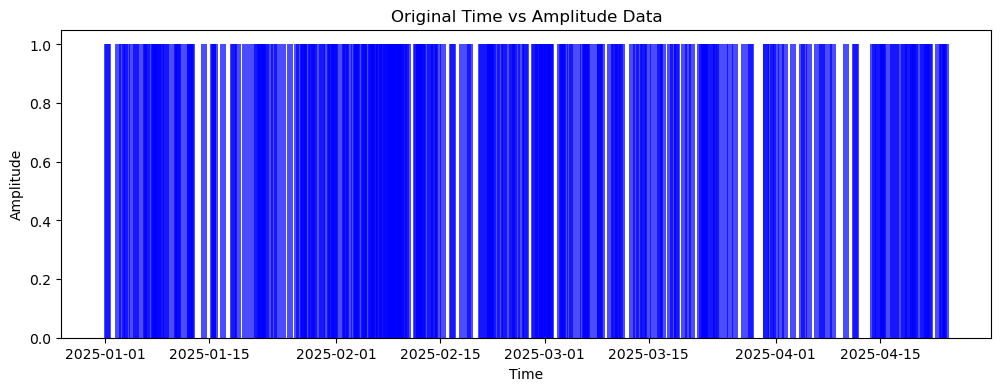

/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methds.py:483: RuntimeWarning: divide by zero encountered in divide
  period = (1 / freq)


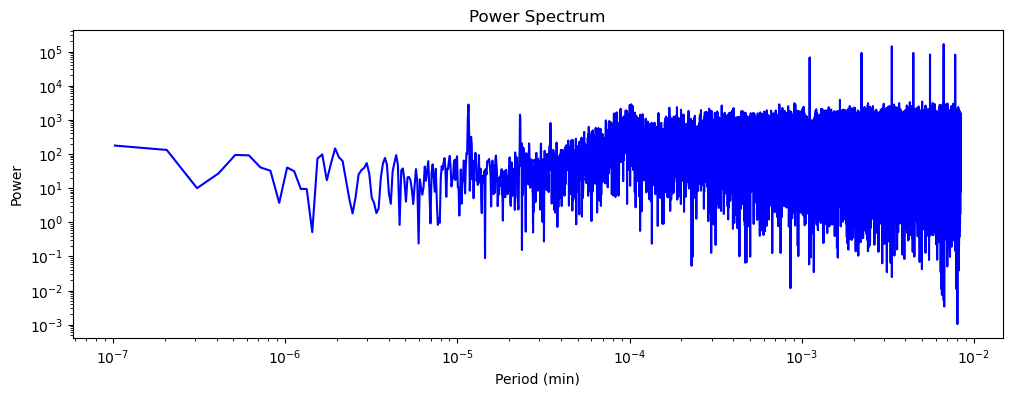

In [20]:
(fig1, ax1), (fig2, ax2) = plot_fft_results(time_bins[::20], time_counts[::20], freq, power_spectrum)

In [21]:
# Report the top 5 peak frequencies
top_5_peak_frequencies = peak_frequencies[np.argsort(power_spectrum[np.isin(freq, peak_frequencies)])][-5:]
print(f"Top 5 peak frequencies are: {(1/top_5_peak_frequencies[::-1])/60}")

Top 5 peak frequencies are: [2.49999229 5.00006165 7.49997688 3.74998844 3.0000185 ]


### Feeding per day of week

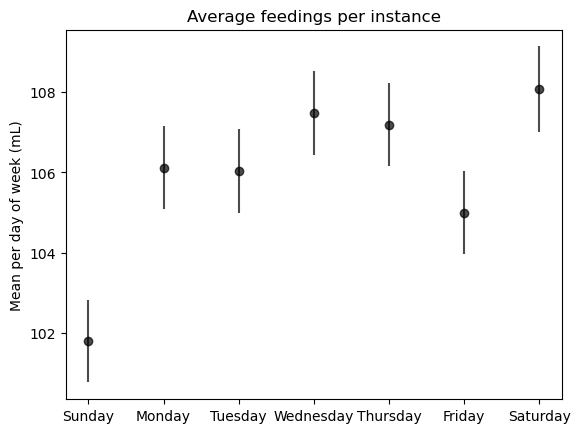

In [22]:
# Group and sum by day
daily_means = group_and_mean_by_day_of_week(get_type_data(full_df, 'bottle'), 'enteredDate', ['bottleAmount'], bottle_err)

plt.errorbar(daily_means['day_of_week'],
             daily_means['bottleAmount_mean'],
             yerr=daily_means['bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week.png")

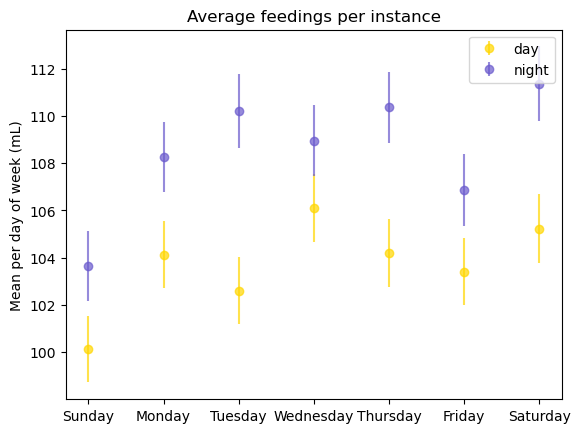

In [23]:
# Group and sum by day

df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')

for period in ['day','night']:
    daily_means = group_and_mean_by_day_of_week(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'], bottle_err)

    plt.errorbar(daily_means['day_of_week'],
                 daily_means['bottleAmount_mean'],
                 yerr=daily_means['bottleAmount_err'],
                 **get_plot_kwargs(period))


plt.legend()
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week_day_night.png")

In [24]:
df = get_type_data(full_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_45689/3198648703.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


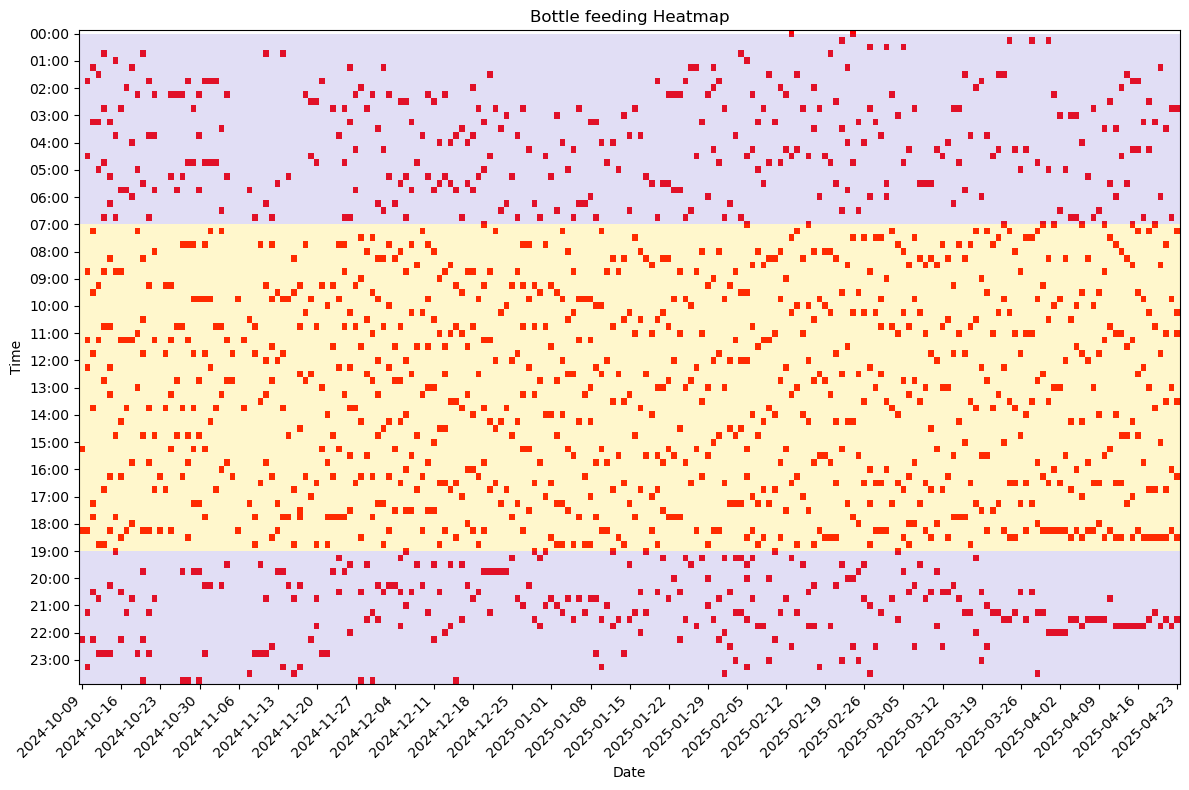

In [25]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-03-01', '2025-03-06')
df = get_type_data(full_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate']+pd.Timedelta(15,'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate']+pd.Timedelta(15,'min')).time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Add horizontal bands
ax.axhspan(0, 7 * 4, facecolor='slateblue', alpha=0.2)  # 0-7 hours (4 steps per hour)
ax.axhspan(7 * 4, 19 * 4, facecolor='gold', alpha=0.2)  # 7-19 hours
ax.axhspan(19 * 4, 24 * 4, facecolor='slateblue', alpha=0.2)  # 19-24 hours

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'red'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 7 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Bottle feeding Heatmap')

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/bottle_map.png")
plt.show()

In [26]:
# Function to limit the display to a specific date range

# Usage example:
# Plot for a specific date range
ax = plot_heatmap_with_date_range('2024-12-21', '2025-05-15')

plt.sca(ax)
plt.savefig("figures/bottle_sleep_heatmap.png")
# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

AttributeError: 'str' object has no attribute 'query'

## Sleeping

### Sleep Durations

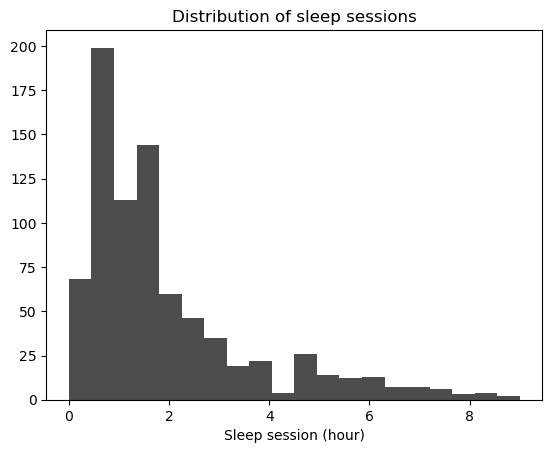

In [139]:
sleep_durations = get_type_data(full_df, 'sleep')[['singleTimerSeconds']].values

plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs('all', plot_type='histogram'))
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist.png")

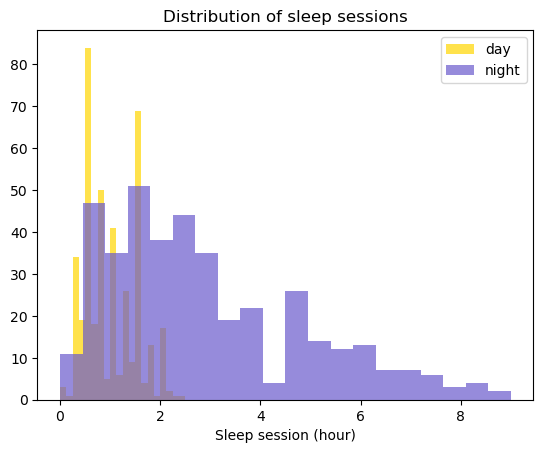

In [140]:
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
for period in ['day','night']:
    sleep_durations = get_timeperiod_data(df, period)[['singleTimerSeconds']].values
    plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs(period, plot_type='histogram'))

plt.legend()
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist_day_night.png")

### Sleep over time, per day

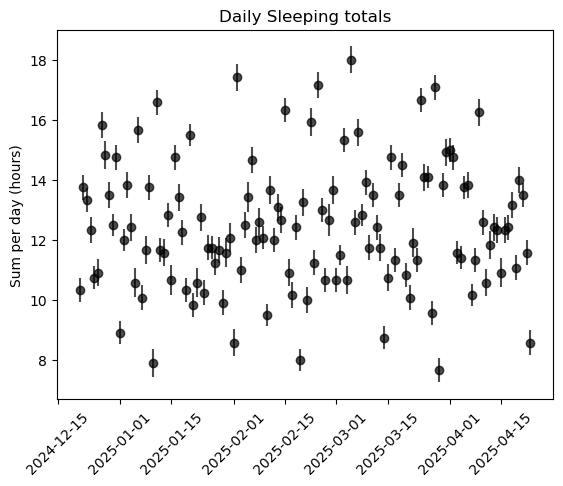

In [141]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))
plt.title("Daily Sleeping totals")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep.png")

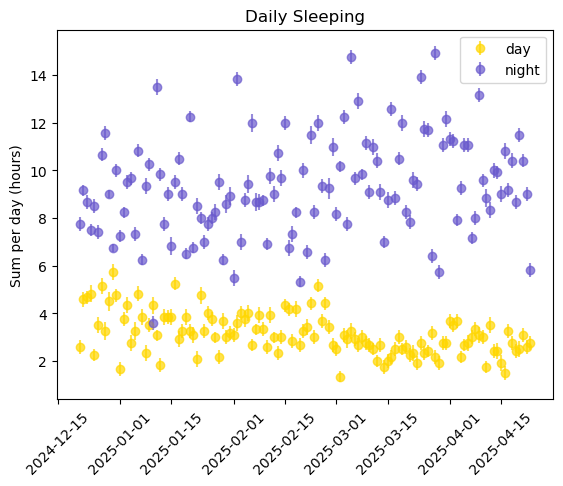

In [142]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night.png")

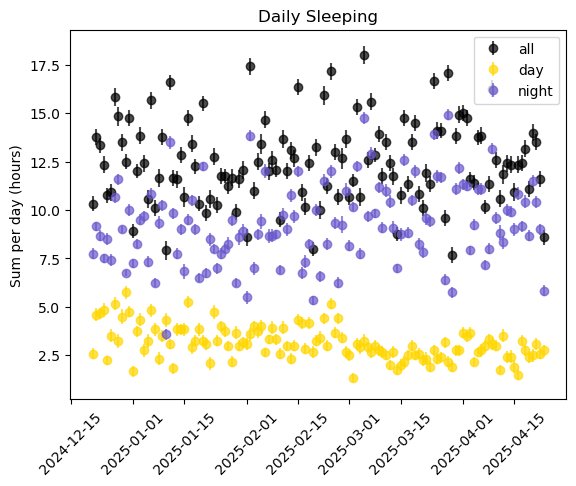

In [143]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night_all.png")

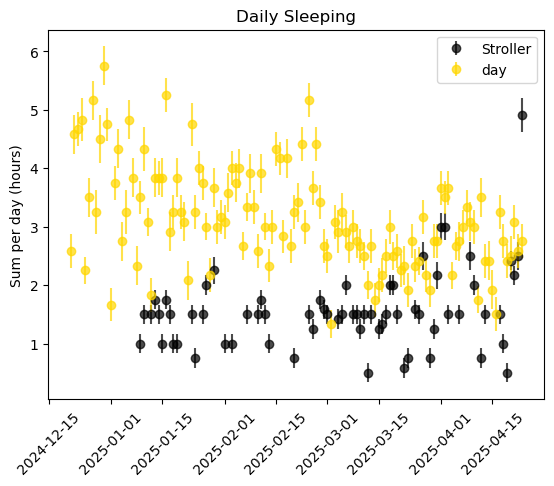

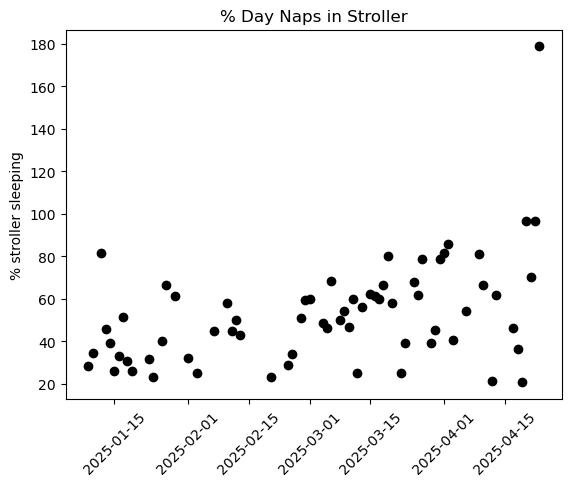

In [144]:
# Group and sum by day
daily_totals_stroller = group_and_sum_durations_by_day(get_type_data(full_df, 'stroll'), ['leftStart', 'leftEnd'], err=sleep_err)

# Add day of week
daily_totals_stroller_with_day = add_day_of_week(daily_totals_stroller, 'leftStart')

plt.errorbar(daily_totals_stroller['leftStart'],
             daily_totals_stroller['event_duration_sum'] / 3600,
             yerr=daily_totals_stroller['event_duration_sum_err']/3600,
             **get_plot_kwargs('all', custom_label='Stroller'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.title("Daily Sleeping")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_stroller.png")

merged_df = pd.merge(daily_totals_stroller, daily_totals,'inner')
plt.figure()
plt.plot(merged_df['leftStart'],
         merged_df['event_duration_sum']/merged_df['singleTimerSeconds_sum']*100,
         marker='o',
         color='k', ls='None'
        )
plt.ylabel("% stroller sleeping")
plt.xticks(rotation=45)
plt.title("% Day Naps in Stroller")
plt.savefig("figures/daily_sleep_stroller_percent.png")

### Sleep per day of week

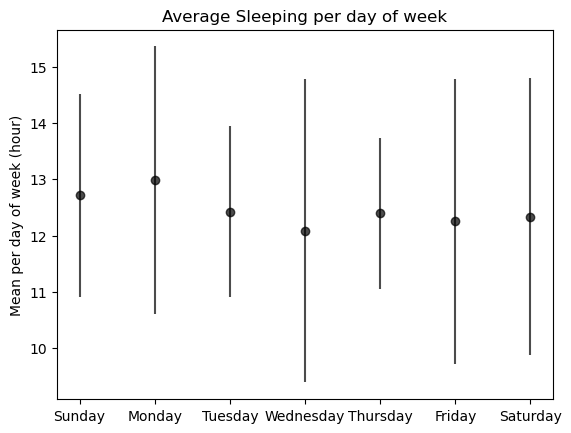

In [145]:
# Group and sum by day
daily_means = group_and_mean_sums_by_day_of_week(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], sleep_err)

plt.errorbar(daily_means['day_of_week'],
             daily_means['singleTimerSeconds_sum_mean'] / 3600,
             yerr=daily_means['singleTimerSeconds_sum_std']/3600,
             **get_plot_kwargs('all'))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday.png")

### How does sum of night sleep impact sum of following day's sleep. Plot night sum vs day sum. Is there a trend line?

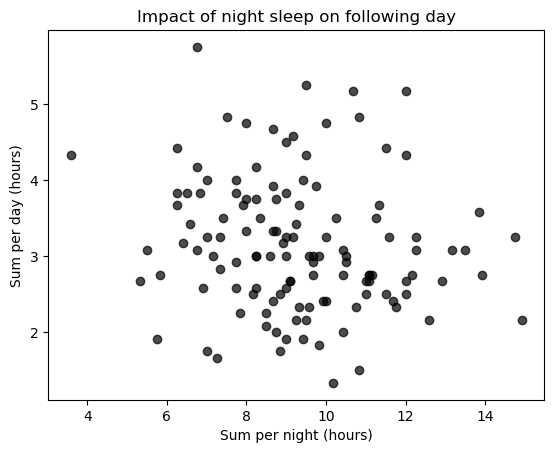

In [146]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
plt.plot(daily_totals_night['singleTimerSeconds_sum'] / 3600,
         daily_totals_day['singleTimerSeconds_sum'] / 3600,
         **get_plot_kwargs('all'))

plt.title("Impact of night sleep on following day")
plt.xlabel("Sum per night (hours)")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/sleep_night_on_day.png")

### How does sum of day sleep impact sum of following night's sleep. Plot day sum vs night sum. Is there a trend line?

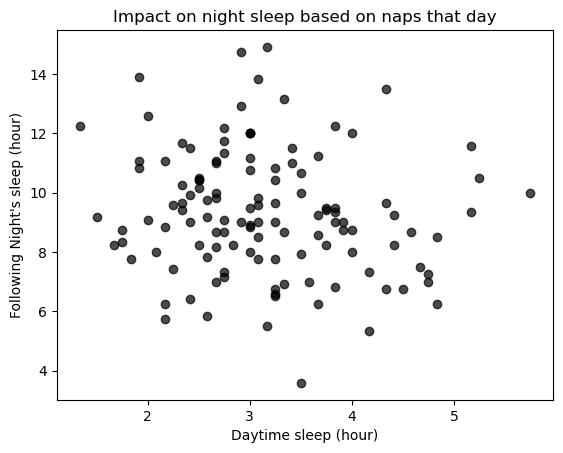

In [147]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'leftStart', '2023-01-01', '2025-05-31')
df = categorize_day_night_start_only(get_type_data(filtered_df, 'sleep'), 'leftStart')

daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

results = get_consecutive_durations_from_two_dfs(daily_totals_day, daily_totals_night, date_column='leftStart', duration_column='singleTimerSeconds_sum')
plt.plot(results[:,1] / 3600,results[:,3] / 3600, **get_plot_kwargs('all'))

plt.xlabel("Daytime sleep (hour)")
plt.ylabel("Following Night's sleep (hour)")
plt.title("Impact on night sleep based on naps that day")
plt.savefig("figures/sleep_day_on_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_43653/3335003140.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


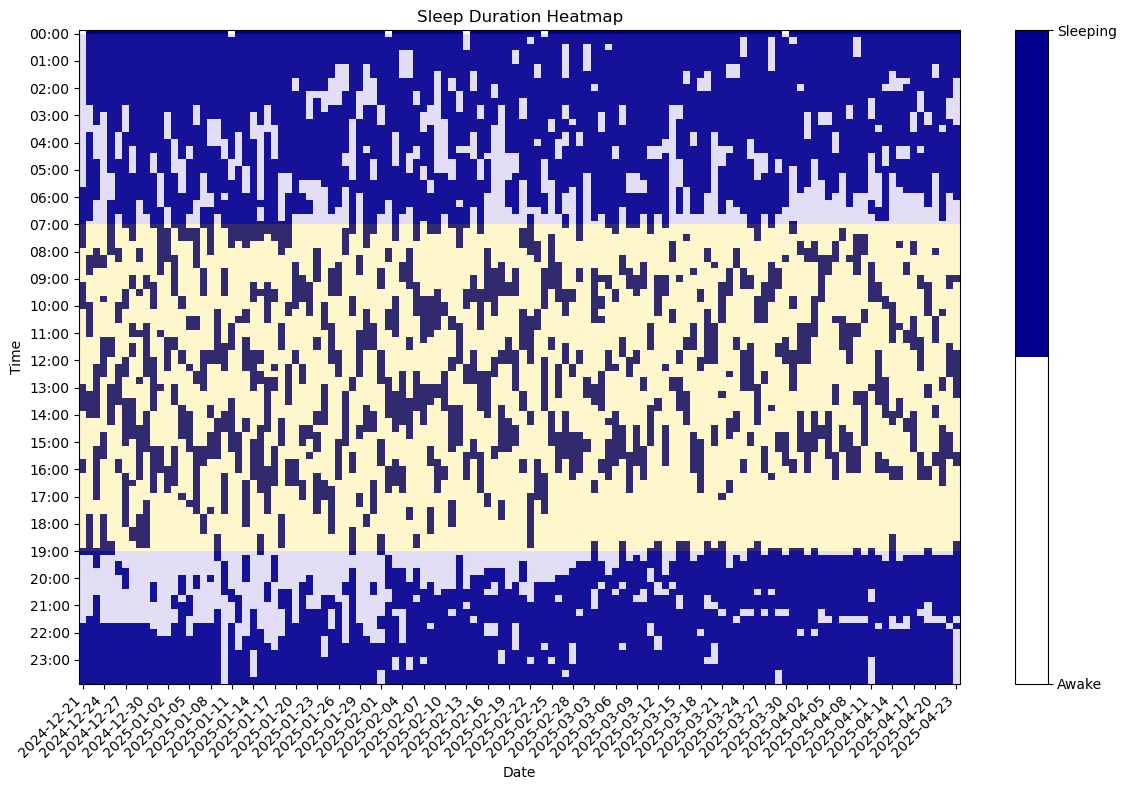

In [148]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-03-01', '2025-03-06')
df = get_type_data(full_df, 'sleep')
date_range = pd.date_range(start=df['leftStart'].min().date(), end=df['leftEnd'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Add horizontal bands
ax.axhspan(0, 7 * 4, facecolor='slateblue', alpha=0.2)  # 0-7 hours (4 steps per hour)
ax.axhspan(7 * 4, 19 * 4, facecolor='gold', alpha=0.2)  # 7-19 hours
ax.axhspan(19 * 4, 24 * 4, facecolor='slateblue', alpha=0.2)  # 19-24 hours

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['white', 'darkblue'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 3 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Sleep Duration Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['Awake', 'Sleeping'])

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/sleep_map.png")
plt.show()

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_43653/3873127229.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


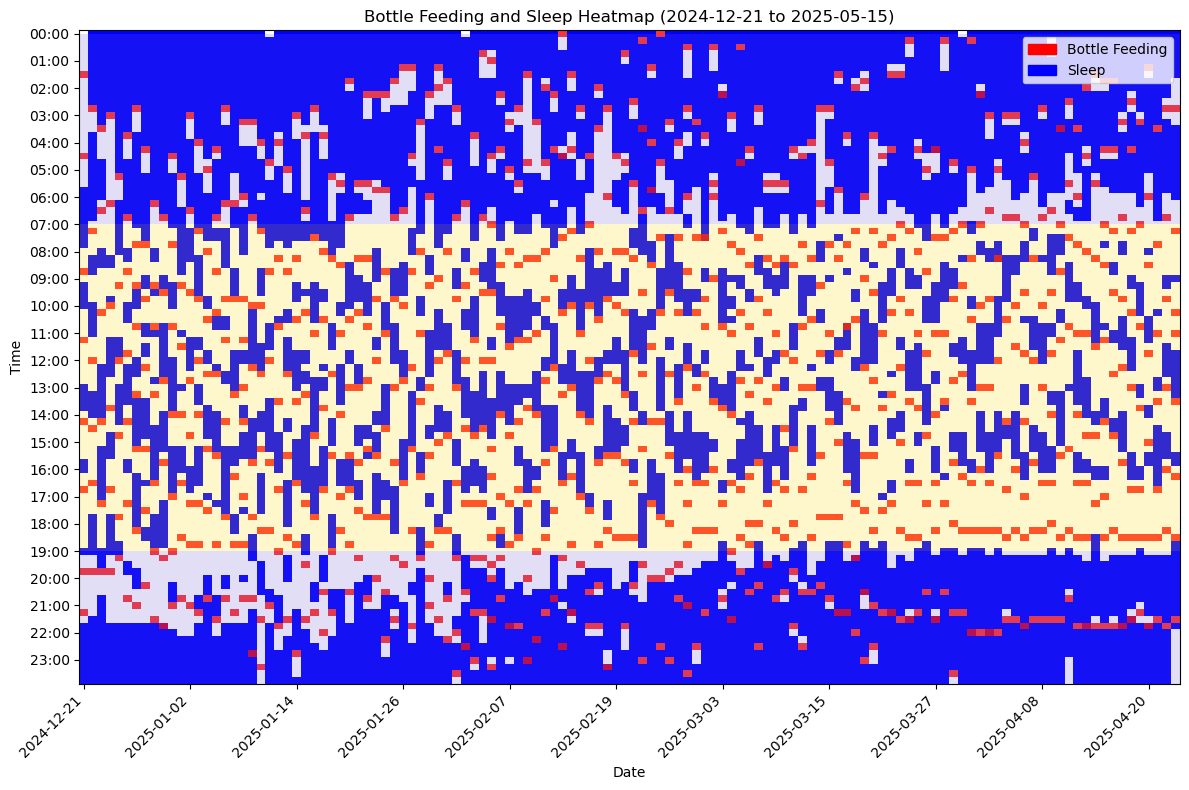

In [149]:


# Usage example:
# Plot for a specific date range
plot_heatmap_with_date_range_transpose('2024-12-21', '2025-05-15')

# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

In [150]:
combined_df = full_df[(full_df['type']=='sleep') | (full_df['type']=='bottle')]
combined_df['combined_date'] = combined_df.apply(lambda row: row['leftStart'] if row['type'] == 'sleep' else row['enteredDate'], axis=1)
combined_df['combined_date'] = pd.to_datetime(combined_df['combined_date'])
df_sorted = combined_df.sort_values(by='combined_date')



(400.0, 600.0)

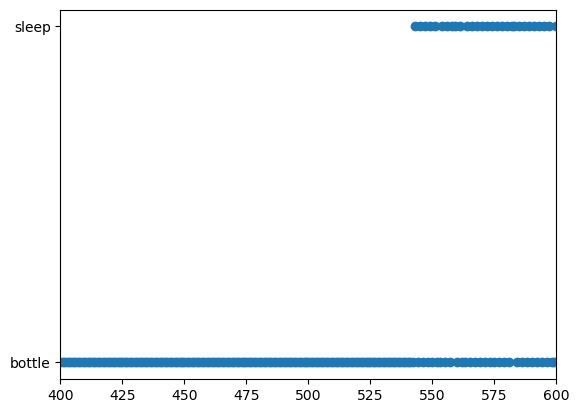

In [151]:
plt.plot(df_sorted['type'].values,'o')
plt.xlim(400,600)

## Vitals

### Growth

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_43653/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_43653/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_43653/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')


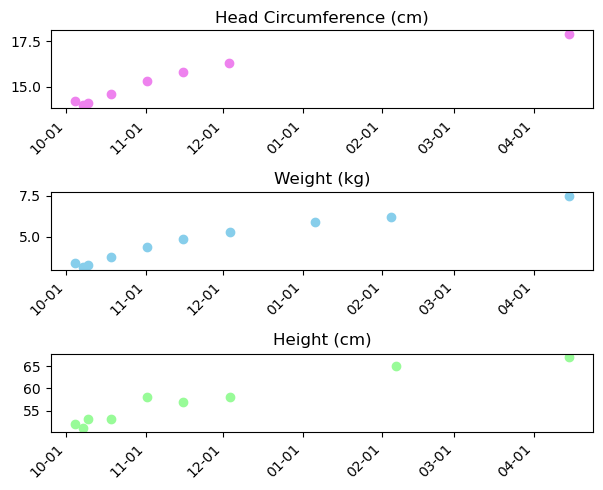

In [152]:
head_circ = get_type_data(full_df, "head_circ")[['enteredDate', 'headCircInches']]
weight = get_type_data(full_df, "weight")[['enteredDate', 'weight']]
height = get_type_data(full_df, "height")[['enteredDate', 'height']]

fig,ax=plt.subplots(3,1, figsize=(6,5))

ax[0].plot(head_circ.values[:,0], head_circ.values[:,1], label='head_circ',marker='o',ls='None', c='violet')
ax[1].plot(weight.values[:,0], weight.values[:,1], label='weight',marker='o',ls='None', c='skyblue')
ax[2].plot(height.values[:,0], height.values[:,1], label='height',marker='o',ls='None', c='palegreen')


ax[0].set_title("Head Circumference (cm)",)
ax[1].set_title("Weight (kg)")
ax[2].set_title("Height (cm)")

date_formatter = mdates.DateFormatter("%m-%d")
for i in range(3):
    # Format x-axis to show only month-day
    ax[i].xaxis.set_major_formatter(date_formatter)

    # Get current tick labels
    labels = ax[i].get_xticklabels()

    # Set the rotated labels
    ax[i].set_xticklabels(labels, rotation=45, ha='right')
    # ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)

plt.tight_layout()
plt.savefig("figures/growth.png")

In [153]:
get_type_data(full_df, "height")[['enteredDate', 'height']]

,enteredDate,height
992,2024-10-04 12:00:55-04:00,52.0
993,2024-10-07 12:00:22-04:00,51.0
994,2024-10-09 12:00:44-04:00,53.0
995,2024-10-18 12:00:04-04:00,53.0
996,2024-11-01 12:00:21-04:00,58.0
997,2024-11-15 12:00:44-05:00,57.0
998,2024-12-03 12:00:04-05:00,58.0
2088,2025-02-06 11:33:52.852000-05:00,65.0
3333,2025-04-14 13:00:10-04:00,67.0


In [154]:
get_type_data(full_df, "height")[['enteredDate', 'height']].values[:, 0]

array([Timestamp('2024-10-04 12:00:55-0400', tz='US/Eastern'),
       Timestamp('2024-10-07 12:00:22-0400', tz='US/Eastern'),
       Timestamp('2024-10-09 12:00:44-0400', tz='US/Eastern'),
       Timestamp('2024-10-18 12:00:04-0400', tz='US/Eastern'),
       Timestamp('2024-11-01 12:00:21-0400', tz='US/Eastern'),
       Timestamp('2024-11-15 12:00:44-0500', tz='US/Eastern'),
       Timestamp('2024-12-03 12:00:04-0500', tz='US/Eastern'),
       Timestamp('2025-02-06 11:33:52.852000-0500', tz='US/Eastern'),
       Timestamp('2025-04-14 13:00:10-0400', tz='US/Eastern')],
      dtype=object)

## Wellbeing

### Baths

21


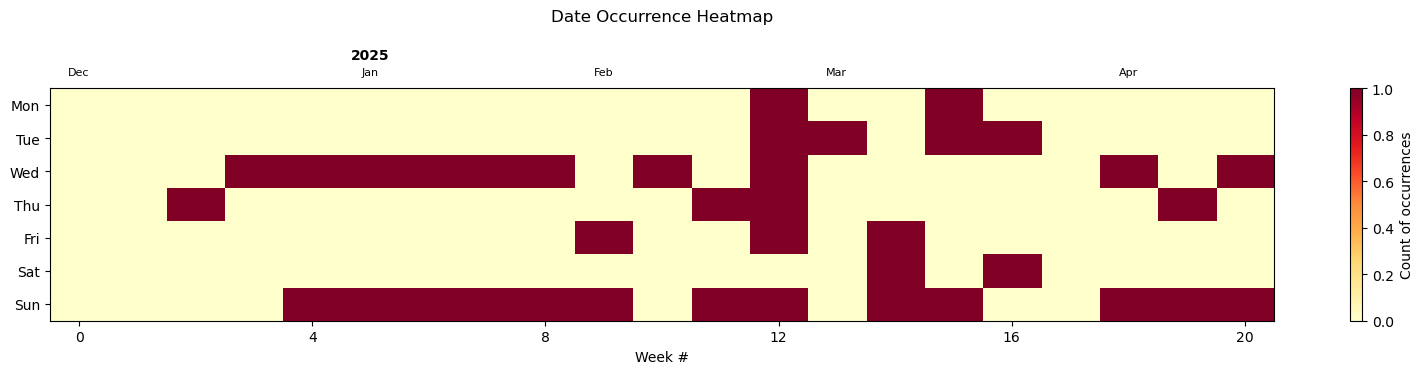

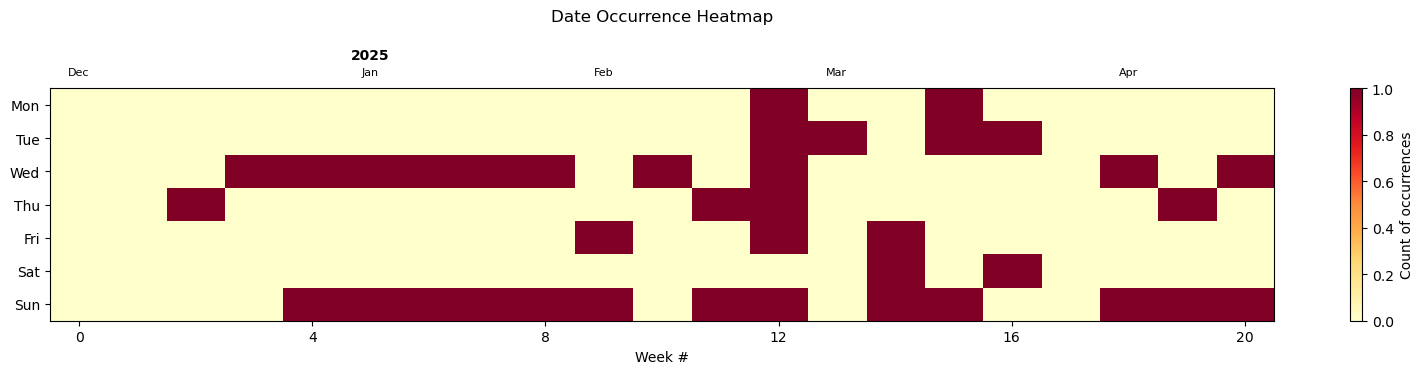

In [155]:
# Convert Series to list of dates
dates = get_type_data(full_df, "bathing")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/bath_map.png")

### Gas Drops

29


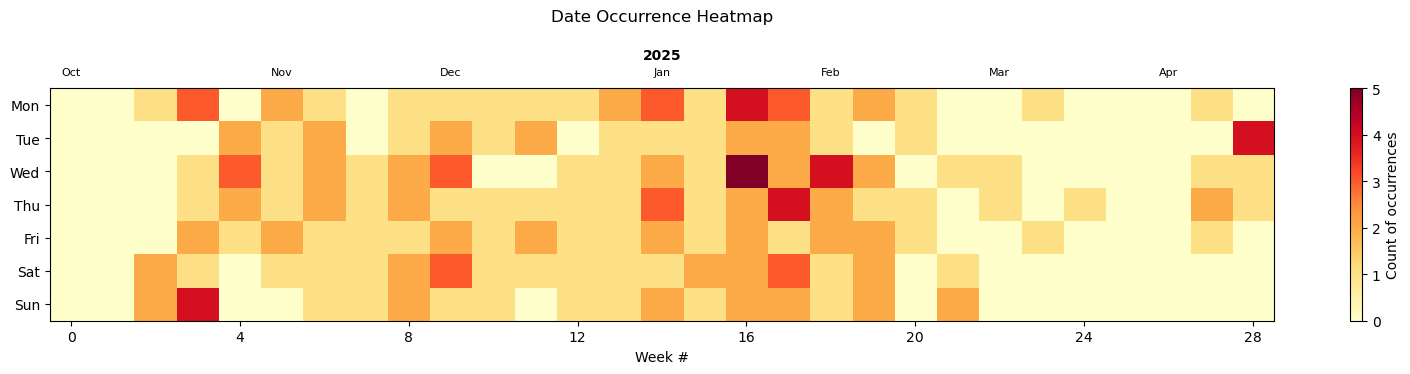

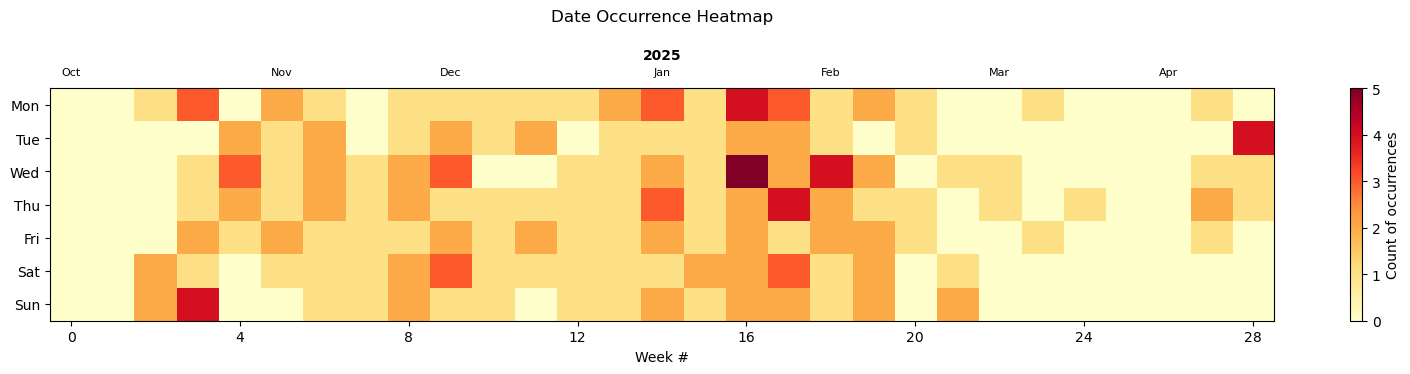

In [156]:
# Convert Series to list of dates
dates = get_type_data(full_df, "taking_med")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/gas_drops_map.png")

### Diapers

30


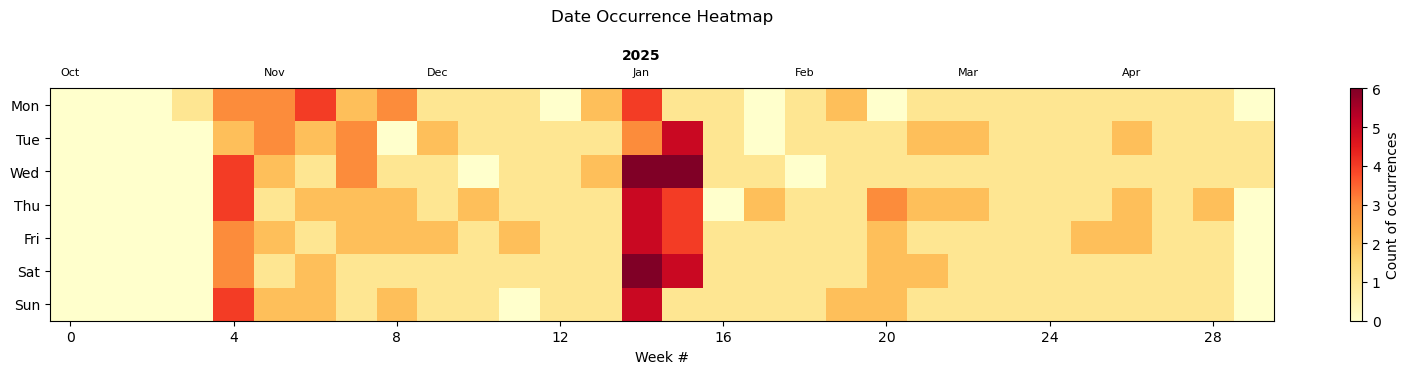

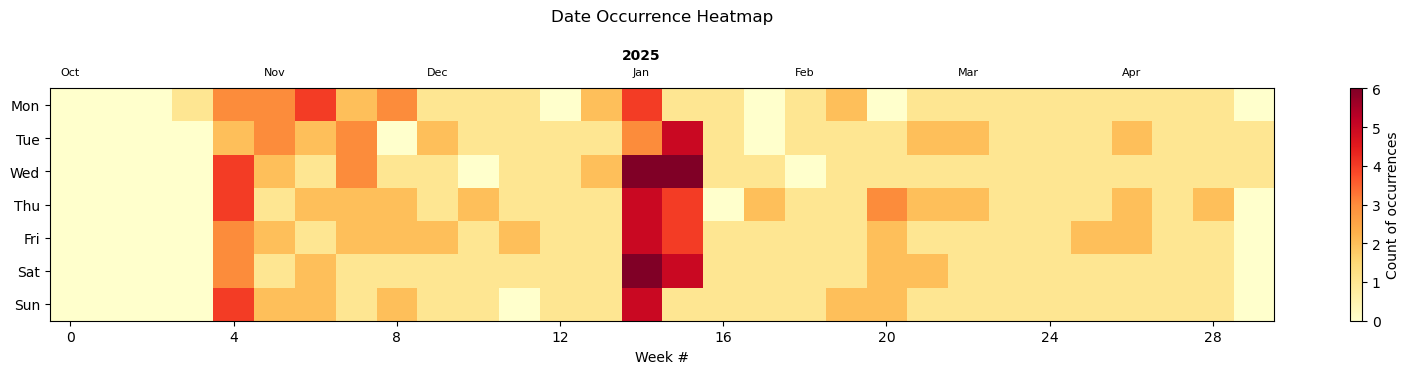

In [157]:
# Convert Series to list of dates
dates = get_type_data(full_df, "diaper")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

30


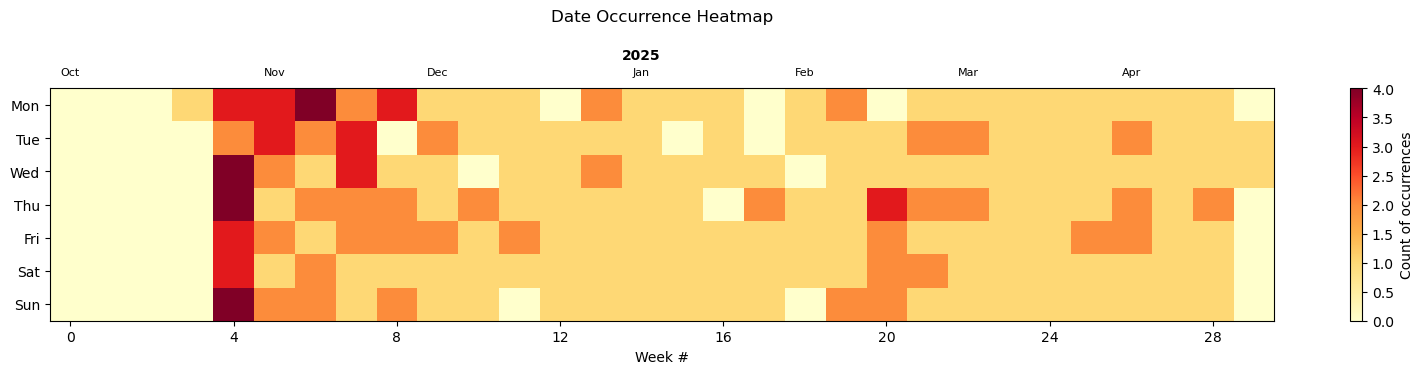

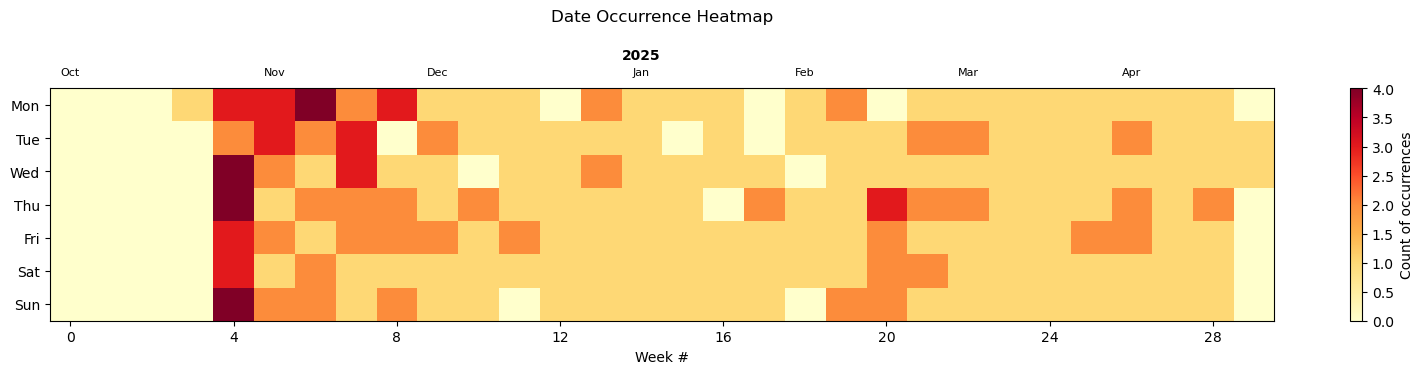

In [158]:
dates= get_type_data(full_df, "diaper").query("customComment=='dirty'")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")